Run `pip install .` first to install all dependencies.

In [1]:
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
!pip install fastparquet
!pip install numpy
!pip install pandas
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from catboost import CatBoostClassifier, Pool
import numpy as np

import gcsfs
import numpy as np
import pandas as pd

import wandb

from sklearn.preprocessing import MinMaxScaler


In [3]:
name = "classical_size_features_accuracy_branch"

# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

dataset = wandb.Artifact(name=name, type="preprocessed_data")


wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
import google.auth
from google.colab import auth
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
#fs = gcsfs.GCSFileSystem(project="thesis")
fs = gcsfs.GCSFileSystem(project="thesis", credentials=credentials)

In [5]:
# reduce number of imported cols due to memory issues
columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]


In [6]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)

In [7]:
from sklearn.preprocessing import MinMaxScaler#QuantileTransformer

In [8]:
# oe_option_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_root = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_issue_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )

scaler = MinMaxScaler(feature_range=[-1, 1])
# scaler = QuantileTransformer(n_quantiles=256)

def transform(data: pd.DataFrame) -> pd.DataFrame:

    # # date features
    x = pd.DataFrame(data={"TRADE_PRICE": data["TRADE_PRICE"]}, index=data.index)

    # log transformed features
    x[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex",
         ]
     ] = data[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex"
         ]
     ]
    

    # TODO: speak with caroline
    # x["bid_ex"].replace({0.0:np.NaN}, inplace=True)
    # x["ask_ex"].replace({0.0:np.NaN}, inplace=True)




    # size features
    x["bid_ask_size_ratio_ex"] = x["bid_size_ex"] / x["ask_size_ex"]
    x["rel_bid_size_ex"] = x["TRADE_SIZE"] / x["bid_size_ex"]
    x["rel_ask_size_ex"] = x["TRADE_SIZE"] / x["ask_size_ex"]
     
    
    # classical
    mid_ex = 0.5 * (x["ask_ex"] + x["bid_ex"])
    mid_best = 0.5 * (x["BEST_ASK"] + x["BEST_BID"])
    spread = (x["ask_ex"] - x["bid_ex"])
    
    
    x["prox_ex"] = (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread) # , (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread))  # combines rel. ask ex and bid ex 
    x["prox_best"] = (data["TRADE_PRICE"] - mid_best) / (0.5 * spread) #, (data["TRADE_PRICE"]- mid_best) / (0.5 * spread))    



    # x["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
    # x["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])

    
    # x["prox_ex"].clip(-10,10, inplace=True)
    # x["prox_best"].clip(-10,10, inplace=True)
    
    # some uncovered comparsions
    # x["ask_ex_best_ratio"] = data["ask_ex"] / data["BEST_ASK"]
    # x["bid_ex_best_ratio"] = data["bid_ex"] / data["BEST_BID"]
    # x["mid_ex_best_ratio"] = mid_ex / mid_best
    x["ask_ex_best_ratio"] = x["ask_ex"]  / x["BEST_ASK"]
    x["bid_ex_best_ratio"] = x["bid_ex"]  / x["BEST_BID"]
    x["mid_ex_best_ratio"] = mid_ex  / mid_best
    
    x["ex_no_trade"] = (x["ask_ex"]==0) | (x["bid_ex"]==0)
    x["spread_ex"] = spread

    x["bid_ask_ratio_ex"] = x["bid_ex"] / x["ask_ex"]
    # x["price_norm_size"] = data["TRADE_PRICE"] / data["TRADE_SIZE"]
    x["price_rel_nbb"] = (x["BEST_ASK"] - data["TRADE_PRICE"]) / (x["BEST_ASK"] - mid_best)
    x["price_rel_nbo"] = (data["TRADE_PRICE"] - x["BEST_BID"]) / (mid_best - x["BEST_BID"])
    
    
        
    # x["price_eq_ask_eq_bid"] = (data["TRADE_PRICE"] == data["ask_ex"]) & (data["TRADE_PRICE"] == data["bid_ex"])
    
    # calculate change
    x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
    x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
    x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
    x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

    # calculate change own creation
    x["chg_ex_lag_lead"] = data["price_ex_lag"] - data["price_ex_lead"]
    x["chg_all_lag_lead"] = data["price_all_lag"] - data["price_all_lead"]

    # impute with zeros
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(-999, inplace=True)

    # # scale to [-1, 1]
    # if not hasattr(scaler, "n_features_in_"):
    #     scaler.fit(x)
    # x[x.columns] = scaler.transform(x)

    # https://stackoverflow.com/questions/70727291/how-do-i-know-whether-a-sklearn-scaler-is-already-fitted-or-not

    # if not hasattr(oe_option_type, "n_features_in_"):
    #     oe_option_type.fit(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))
    # x["bin_option_type"] = oe_option_type.transform(
    #     data["OPTION_TYPE"].astype(str).values.reshape(-1, 1)
    # )

    # if not hasattr(oe_root, "n_features_in_"):
    #     oe_root.fit(data["ROOT"].astype(str).values.reshape(-1, 1))
    # x["bin_root"] = oe_root.transform(data["ROOT"].astype(str).values.reshape(-1, 1))

    # if not hasattr(oe_issue_type, "n_features_in_"):
    #     oe_issue_type.fit(data["issue_type"].astype(str).values.reshape(-1, 1))
    # x["bin_issue_type"] = oe_issue_type.transform(
    #     data["issue_type"].astype(str).values.reshape(-1, 1)
    # )

    # x.replace([np.inf, -np.inf], np.nan, inplace=True)

    x["buy_sell"] = data["buy_sell"]
    return x


In [9]:
X_train = transform(train)
y_train = X_train.buy_sell
X_train.drop(columns=["buy_sell"], inplace=True)

del train

In [10]:
X_val = transform(val)
y_val = X_val.buy_sell
X_val.drop(columns=["buy_sell"], inplace=True)
del val

In [54]:
params = {
        "od_type": "Iter",
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
        "iterations":5000,
        "early_stopping_rounds":100,
        "grow_policy":"Lossguide"
}

#Lossguide, "grow_policy"

# lam = 0#0.25

#x = X_train.index.values / np.linalg.norm(X_train.index)
#x = (X_train.index.values - X_train.index.min()) / (X_train.index.max() - X_train.index.min())

# (v1-min(v1))/(max(v1)-min(v1))

#print(x)
# x = np.linspace(0,1, num=len(X_train))
#weight = np.exp(-lam * x)[::-1]
#weight = np.linspace(0,1, num=len(X_train))
#weight = np.geomspace(1e-4,1,num=len(X_train))
#print(weight)

model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train,weight = X_train.index.values)
model.fit(train_pool, eval_set=(X_val,y_val))

print(model.score(X_val, y_val))

0.7472744193615647


## Sanity Check against `lightgbm`

In [12]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import lightgbm as lgb

In [44]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':None,
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':200,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 42,
                    'eval_metric':'accuracy',
                    "device": "cpu",
                }

In [15]:
# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train,weight=X_train.index.values, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=False)

In [46]:
bst = lgb.LGBMClassifier(**lgb_params)
bst = lgb.train(lgb_params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                early_stopping_rounds=100
)

[1]	valid_0's binary_logloss: 0.688745
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.685403
[3]	valid_0's binary_logloss: 0.682149
[4]	valid_0's binary_logloss: 0.678925
[5]	valid_0's binary_logloss: 0.675801
[6]	valid_0's binary_logloss: 0.672734
[7]	valid_0's binary_logloss: 0.669728
[8]	valid_0's binary_logloss: 0.666893
[9]	valid_0's binary_logloss: 0.665231
[10]	valid_0's binary_logloss: 0.662429
[11]	valid_0's binary_logloss: 0.659956
[12]	valid_0's binary_logloss: 0.657285
[13]	valid_0's binary_logloss: 0.654607
[14]	valid_0's binary_logloss: 0.652026
[15]	valid_0's binary_logloss: 0.649538
[16]	valid_0's binary_logloss: 0.647188
[17]	valid_0's binary_logloss: 0.644708
[18]	valid_0's binary_logloss: 0.64235
[19]	valid_0's binary_logloss: 0.639979
[20]	valid_0's binary_logloss: 0.637636
[21]	valid_0's binary_logloss: 0.635597
[22]	valid_0's binary_logloss: 0.633417
[23]	valid_0's binary_logloss: 0.631188
[24]	valid_0's binary_loglo

In [53]:
pred = bst.predict(X_val)
pred = np.rint(pred)
pred[pred==0]=-1
print((y_val == pred).mean())

0.734219907748796


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17fbce43a0>,
      dtype=object)

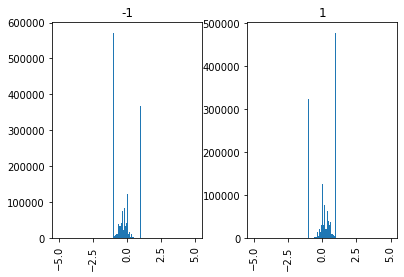

In [83]:
X_train.prox_ex.hist(bins=128, range=[-5,5], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8851eb9ac0>,
      dtype=object)

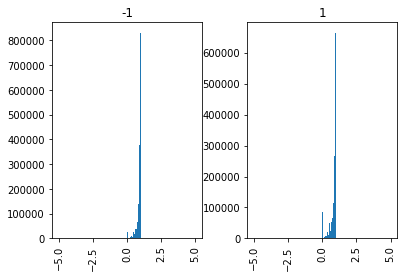

In [23]:
X_train["bid_ask_ratio_ex"].hist(bins=128, range=[-5,5], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17fcce6520>,
      dtype=object)

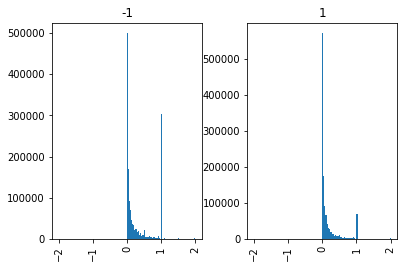

In [62]:
X_train["rel_ask_size_ex"].hist(bins=128, range=[-2,2], by=y_train)

## Results

In [ ]:
# 0.7434765583282902 without any scaler, zero imputer, symmetric tree
# 0.7445394305242655 "grow_policy" = "Lossguide" -> trained for 5000 iterations
# 0.7450428963013065 impute with -999 instead of 0 -> trained for 5000 iterations
# 0.7436240382023729 TODO: ask Caroline: What happens with LR if bid_ex = 0 or ask_ex is?   x["bid_ex"].replace({0.0:np.NaN}, inplace=True) and  x["ask_ex"].replace({0.0:np.NaN}, inplace=True)
# 0.7447164063731647 chg from previous trade to successive trade
# 0.7445821488326205 chg from previous trade + no trade indicator
# 0.7476558328290199 "spread" feature  

In [ ]:
# 0.7333797810178145 (logs applied) to     x["bid_ask_size_ratio_ex"] x["rel_bid_size_ex"]   x["rel_ask_size_ex"] 
# 0.7331946683482763 (all from above + log returns)
# 0.734859665271541 (all above + compare mids, ask, and bid at exchange with nation wide)
# 0.7349013664773161 (all above + trade_price == bid_ex == ask_ex)
# 0.7351464881990674 (price normed size)
# 0.7352807457396116 (all above +  x["price_rel_nbo"] +  x["price_rel_nbb"])
# 0.74296292 (some removed, see above, max. iterations reached. Actually there is no reason to stop ensemble)
# 0.745053067 convert some ratios to percentages (all other things the same as above)
# robust scaler with log (ca. 74.4)
# robust scaler without log 0.74342061

# 0.74356606
# 0.74381220

In [14]:
# feature importances of catboost
feature_importance = model.get_feature_importance(prettified=True)
feature_importance


,Feature Id,Importances
0,bid_ask_size_ratio_ex,14.776020
1,ask_size_ex,14.110684
2,bid_size_ex,12.555628
3,prox_ex,12.456708
4,price_rel_nbb,10.617719
5,price_rel_nbo,6.602805
6,spread_ex,5.034344
7,rel_bid_size_ex,4.628601
8,rel_ask_size_ex,3.777252
9,prox_best,3.334674


In [ ]:
# 	Feature Id	Importances
# 0	ask_size_ex	12.525492
# 1	bid_size_ex	11.546952
# 2	rel_ask_ex	10.194505
# 3	bid_ask_size_ratio_ex	8.590138
# 4	rel_bid_ex	7.966504
# 5	rel_bid_size_ex	5.996297
# 6	BEST_rel_ask	4.807563
# 7	rel_ask_size_ex	4.260232
# 8	price_rel_nbo	3.670372
# 9	bid_ask_ratio_ex	3.384097
# 10	BEST_rel_bid	3.284908
# 11	price_rel_nbb	3.269674
# 12	TRADE_SIZE	3.073776
# 13	chg_all_lead	2.350704
# 14	chg_all_lag	1.966295
# 15	bid_ex_best_ratio	1.587316
# 16	ask_ex	1.578785
# 17	ask_ex_best_ratio	1.347937
# 18	chg_ex_lead	1.182017
# 19	TRADE_PRICE	1.073262
# 20	BEST_ASK	1.031167
# 21	bid_ex	0.923878
# 22	mid_ex_best_ratio	0.902499
# 23	BEST_BID	0.847981
# 24	price_all_lead	0.784676
# 25	chg_ex_lag	0.711833
# 26	price_ex_lead	0.594340
# 27	price_ex_lag	0.278488
# 28	price_all_lag	0.268311

In [ ]:
X_train.prox_ex.hist(bins=256)

In [ ]:
X_train.prox_ex.head(20)